In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil, math, sys
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import SGD
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import mark_boundaries
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [2]:
import skimage

0.16.2


# X-ray Classification Model

In [3]:
%load_ext autoreload
%autoreload 2
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

## Overview
I have been tasked to build a deep neural network to train on a data set of x-ray images of pediatric patients to identify whether or not they have pneumonia. This data is sourced from Kermany et al. on Mendeley, however I personally used a version on Kaggle due to it being easier to use. The data originally consists of 5216 images in the training set, 624 in the test set, and 16 for the validation set. 

First I set up the paths and transfered images from the validation set to the test set.

In [4]:
train_path = os.path.join('chest_xray', 'train')
test_path = os.path.join('chest_xray', 'test')
val_path = os.path.join('chest_xray', 'val')

In [5]:
datagen = ImageDataGenerator()

train_gen = datagen.flow_from_directory(train_path)
test_gen = datagen.flow_from_directory(test_path)
val_gen = datagen.flow_from_directory(val_path)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


Using SGD as my optimizer for all of my models. I tuned the learning rate to 1e-5.

In [6]:
opt = SGD(learning_rate=1*10**-5)

## Methods
I am going through and checking different deep neural network architectures to see which one works best with the data. I ran into the issue that I didnt have enough images in my validation set so I brought some of the test images over in order to better interpret how my models perform. I ended up with 141 images for my validation set. After choosing which architecture to use I tune it to do my best to get the highest accuracy without overfitting on the data. I then used the package lime to see what parts of the images were being used to predict whether or not a patient has pneumonia.

In [7]:
def visualize_training_results(results):
    """Function that graphs and displays both loss and accuracy for a neural networks history.
    Orginal code from Deeper-Neural-Networks-lab"""
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

I set up my baseline model in order to make sure everything is running smoothly before running my more complicated networks. I ened with an accuracy of 61% but the results were very inconclusive although the model did what it was supposed to do.

My next model is a simple convolution network. I got a accuracy of 78% and ended up with over 16 million trainable parameters but with a lot of evidence of overfitting with my validation loss hovering around 10 while the training loss approaches 0.

My next model was the popular AlexNet. The normalization layers help with the overfitting but there is still some going on. The validation accuracy reached to 72% which isn't bad. 

For more information about these models check out the [Pre-Updated Validation Set Notebook](./MaidenVoyage.ipynb) and [Post-Updated Validation Set Notebook](./UpdatedValidation.ipynb)

## Results
The model that performed the best ended up being a simple residual network. I tried to expand the res-net [here]('FinalModel.ipynb') in order to better predict but ended up overloading my cpu and was unable to run it. I ended up only being able to generate approx. 75,000 trainable parameters compared to the 2,000,000 trainable parameters I generated with the simple res-net. With a validation accuracy of 78% the simple res-net is the best choice to predict whether or not a patient has pneumonia.

In [9]:
from tensorflow.keras import Model

def SimpleResNet(image_shape):
    input_layer = layers.Input(image_shape)
    
    X = layers.Conv2D(16, (3,3), activation='relu')(input_layer)
    X = layers.BatchNormalization()(X)
    
    X_shortcut = X
    
    X = layers.Conv2D(16, (3,3), padding='same', activation='relu')(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Add()([X, X_shortcut]) #Skip Connection
    X = layers.Activation('relu')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(2, activation='sigmoid')(X)
    
    model = Model(inputs=input_layer, outputs=X, name='ResNet')
    
    model.compile(loss='binary_crossentropy',
                 optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [10]:
model_4 = SimpleResNet(train_gen.image_shape)
model_4.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 254, 254, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 254, 254, 16) 2320        batch_normalization[0][0]        
_____________________________________________________________________________________________

2021-10-19 15:45:20.114804: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
results_4 = model_4.fit(train_gen, validation_data=val_gen, epochs=8)

2021-10-19 15:46:16.973757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8
163/163 [==============================] - 303s 2s/step - loss: 0.4872 - accuracy: 0.8133 - val_loss: 0.7490 - val_accuracy: 0.7234
Epoch 2/8
163/163 [==============================] - 282s 2s/step - loss: 0.2670 - accuracy: 0.9126 - val_loss: 0.7633 - val_accuracy: 0.7660
Epoch 3/8
163/163 [==============================] - 284s 2s/step - loss: 0.2019 - accuracy: 0.9425 - val_loss: 0.7714 - val_accuracy: 0.7801
Epoch 4/8
163/163 [==============================] - 281s 2s/step - loss: 0.1660 - accuracy: 0.9519 - val_loss: 0.8221 - val_accuracy: 0.7943
Epoch 5/8
163/163 [==============================] - 281s 2s/step - loss: 0.1425 - accuracy: 0.9592 - val_loss: 0.8410 - val_accuracy: 0.8014
Epoch 6/8
163/163 [==============================] - 283s 2s/step - loss: 0.1250 - accuracy: 0.9651 - val_loss: 0.8600 - val_accuracy: 0.7872
Epoch 7/8
163/163 [==============================] - 280s 2s/step - loss: 0.1130 - accuracy: 0.9712 - val_loss: 0.8326 - val_accuracy: 0.8085
Epoch 

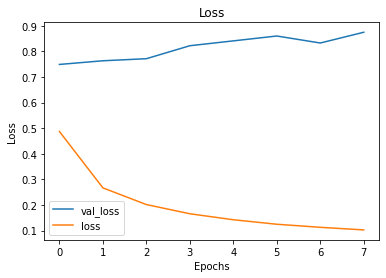

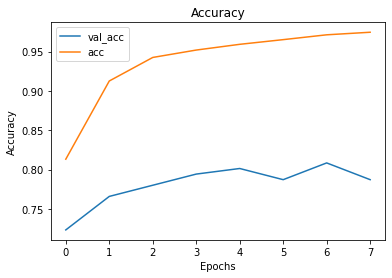

In [12]:
visualize_training_results(results_4)

Using my chosen model, I ran it against the test data and ended up with an accuracy of 59%. Which given the overfitting found in my model is pretty good.

In [49]:
def get_labels(model, gen, threshold = 0.5):
    preds = model.predict(gen)
    return (preds[:,1]>threshold).astype(int)
    

In [58]:
accuracy_score(test_gen.labels, get_labels(model_4, test_gen))

0.5881410256410257

I used the package lime and the code from [here](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb) in order to see which parts of the images are being used to predict.

In [44]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(256, 256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


In [57]:
pos_test_images = transform_img_fn([os.path.join(test_pos_path, names) for names in test_pos_names])
neg_test_images = transform_img_fn([os.path.join(test_neg_path, names) for names in test_neg_names])

In [62]:
images = np.concatenate((pos_test_images, neg_test_images), axis=0)
images.shape

(624, 256, 256, 3)

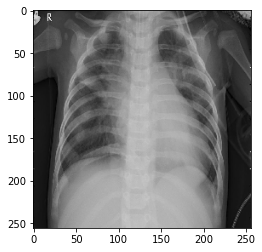

In [83]:
plt.imshow(images[0] / 2 + 0.5)
preds = model_4.predict(images)
explainer = lime_image.LimeImageExplainer()


In [77]:
explanation = explainer.explain_instance(images[0].astype('double'),\
                                         model_4.predict, top_labels=5,\
                                         hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

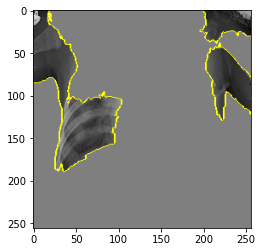

In [79]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

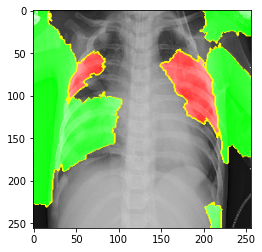

In [80]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

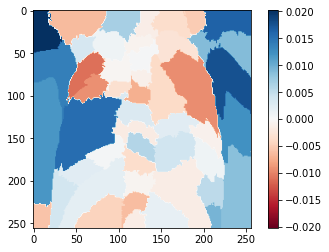

In [81]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Next Step
The next step is to add regularization layers in order to combat overfitting which was found in nearly every model. Then the best idea would be to get in contact with a radiologist and go over all the lime results to make sure the model is using the correct parts of the images to predict. 